# Scheduling operations
In this notebook we will cover the QGym `Scheduling` environment.

This environment is aimed at finding the shortest possible schedules of operations defined by random quantum circuits, whilst taking hardware constraints and commutation rules into account.

In [ ]:
%matplotlib inline
import numpy as np
import networkx as nx
from networkx.generators import fast_gnp_random_graph
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from IPython.display import clear_output

from qgym.custom_types import Gate
from qgym.envs.scheduling import Scheduling
from qgym.envs.scheduling.scheduling_rewarders import EpisodeRewarder

In [ ]:
def render_rgb(step, rgb_array):
    clear_output(wait=True)
    plt.figure(figsize=(40, 20))
    plt.title(f"Step {step}", fontsize=40)
    plt.imshow(rgb_array)
    plt.axis("off")
    plt.show()

### Circuits

The scheduling problem consist of scheduling the operations described by quantum circuit. 
In this model a quantum circuit is defined as a list of gates, where a gate is a `namedtuple` with a `name`, `q1` and `q2`.
For example a c-not with control qubit 2 and target qubit 5 would be `Gate("cnot", 2, 5)` and a X gate acting on qubit 4 would be `Gate("x", 4, 4)`.
In this representation, the circuit below is given by `[Gate("x", 1,1), Gate("cnot", 1,0), Gate("x", 0,0), Gate("h", 1,1)]`.
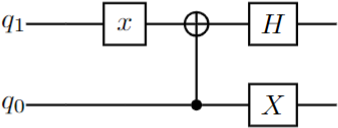


###  Hardware specifications

Different operations defined by a quantum circuit have different operation times, which are defined in the unit of machine cycles.
For example, a X gate could take 2 machine cycles, whereas a measurement could take 15 cycles.
These different operation times must be taken into account, because only one operation can be performed on a qubit at the same time.

Finding a optimal schedule with these restriction is already a difficult task.
However, to complicate matters there are also certain limitations defined by the hardware.
To be more concrete, we take two types of limitations into account:

1. Some gates must start at the same time, or must wait till the previous one is finished. This is typically the case for measurements.
2. Some gates can't be executed in the same cycle. This for example happens often with X, Y and Z gates.


The goal of this scheduling problem is to find an optimal schedule which takes these hardware limitations into account, as well as some optional commutation rules.

### Toy hardware

To explain this concept in more detail we start by defining a some toy hardware specifications.


In [ ]:
hardware_spec = {
    "qubit_number": 2,
    "gates": {
        "x": 2,
        "y": 2,
        "cnot": 4,
        "measure": 10,
    },
    "machine_restrictions": {
        "same_start": {"measure"},
        "not_in_same_cycle": {"x": ["y"], "y": ["x"]},
    },
}

### `Scheduling` environment

The `Scheduling` environment can be initialized by providing:
- hardware specifications; and
- a maximum circuit length, measured in the total number of gates of the circuit.

In [ ]:
env = Scheduling(hardware_spec, max_gates=6, random_circuit_mode="workshop")

#### State space
The state space is described by a dictionary with the following structure:

- `max_gates`: Maximum circuit length.
- `n_qubits`: Number of physical qubits.
- `gate_cycle_length`: Mapping of integer encoded gates and their respective cycle length.
- `same_start`: Set of integer encoded gates that should start in the same cycle.
- `not_in_same_cycle`: Mapping of integer encoded gates that can't start in the same cycle.
- `steps_done`: Number of steps done since the last reset.
- `cycle`: Cycle we are currently in.
- `busy`: Used internally for the hardware limitations.
- `dependencies`: Shows the first $n$ gates that must be scheduled before this gate.
- `encoded_circuit`: Integer encoded representation of the circuit to schedule.
- `gate_names`: Gate names of the encoded circuit.
- `acts_on`: q1 and q2 of each gate.
- `legal_actions`: Array of legal actions. If the value at index $i$ determines if gate number $i$ can be scheduled or not. This array is baded on the machine restrictions and commutation rules.

In [ ]:
env.reset()
print(env._state)

#### Observation space

Each element in the observation space is a dictionary with 2 entries:
- `gate_names`: Gate names of the encoded circuit.
- `acts_on`: q1 and q2 of each gate.
- `dependencies`: Shows the first $n$ gates that must be scheduled before this gate.
- `legal_actions`: List of legal actions. If the value at index  $i$  determines if gate number $i$ can be scheduled or not.

In [ ]:
print(env.observation_space)
print()
print(env.reset())

#### Action space

Performing a quantum operation takes a certain amount of time, which will be measured in (machine) cycles.
Therefore, this environment  aims to produces a schedule in terms of cycles.
To do this, the  environment  schedules the circuit from right to left, so cycle zero in the schedule is the last operation to be performed in that schedule.
Based on this idea, a valid action is then a tuple of an integer $i\in\{0,1,\ldots,$ `max_gates`$\}$ and a binary value $j$.
The integer value $i$ schedules gate $i$ in the current cycle and the binary value $j$ increment the cycle number.

If the action is illegal (for example when we try to schedule a gate that has been scheduled already), then the environment will do nothing and the rewarder should give a penalty for this.

In [ ]:
print(env.action_space)

#### Rewarders

We have pre-defined 2 different rewarders, which return a penalty when an illegal action is attempted, for a valid action their behavior is as follows:


- `BasicRewarder`: Every step gives a reward.
- `EpisodeRewarder`: Only the final step results in a reward.

Both rewarders can be tweaked by altering either of their parameters:

- `illegal_action_penalty`: penalty given for attempting an illegal action (should be non-positive)
- `update_cycle_penalty`: penalty given for incrementing the cycle (should be non-positive)
- `schedule_gate_bonus`: reward given for correctly scheduling a gate (should be non-negative)

<br/>
<br/>
<br/>
<br/>

### Reinforcement learning

Can we achieve useful schedules with reinforcement learning?

Does changing the rewarder and/or its parameter give better results?

In [ ]:
env.rewarder = BasicRewarder(illegal_action_penalty=-10)
check_env(env, warn=True)

model = PPO("MultiInputPolicy", env, verbose=1)

model.learn(int(1e5))

Let's give it the circuit below and see what kind of schedule the agent produces.

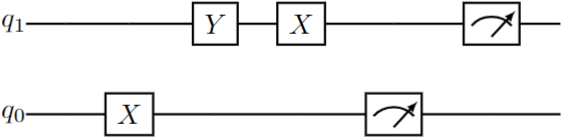

In [ ]:
circuit = [Gate("x", 0, 0), Gate("y", 1, 1), Gate("x", 1, 1), Gate("measure", 0, 0), Gate("measure", 1, 1)] 
obs = env.reset(circuit = circuit)
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env.step(action)
    render_rgb(i, env.render(mode="rgb_array"))
    if done:
        break

Let's also try some randomly generated circuits.

In [ ]:
obs = env.reset()
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env.step(action)
    render_rgb(i, env.render(mode="rgb_array"))
    if done:
        break